# Simple test

In [87]:
from estimators.ccb import pdis_cressieread
from estimators.bandits import snips, ips
from estimators.bandits import clopper_pearson

cb_est = snips.Estimator()
cb_int = clopper_pearson.Interval()

ccb_est = pdis_cressieread.Estimator()
ccb_int = pdis_cressieread.Interval()

In [88]:
ccb_est.add_example([0.1, 0.1, 0.1], [1,2,3], [0.5, 0.5, 0.5])
print(f'estimate: {ccb_est.get()}')

ccb_int.add_example([0.1, 0.1, 0.1], [1,2,3], [0.5, 0.5, 0.5])
print(f'interval: {ccb_int.get()}')

estimate: [1.0, 2.0, 3.0000000000000426]
interval: [[0, 1], [0, 1], [0, 1]]


In [89]:
                #action 0           #action 1
# slot 0           1                    0
# slot 1           0                    0.8
ccb_est = pdis_cressieread.Estimator()
epsilon = 0.1
for i in range(1000):
    ccb_est.add_example(
        p_preds = [1 - epsilon if i%2 else epsilon, 1],
        rs = [i % 2, 0.8 * (i % 2)],
        p_logs = [0.5, 1])
print(f'estimate: {ccb_est.get()}')

estimate: [0.900224424911165, 0.7201795399289322]


# Simulator

In [90]:
# a0, a1, a2
# s0, s1

# matrix of rewards r_ij (i is 0,1, j is 0,1,2)
# online policy: epsilon greedy 

#%matplotlib widget
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def explore(self, n):
        return self.epsilon / n

    def exploit(self, n):
        return self.epsilon / n + 1 - self.epsilon

def baseline_random(n):
    return [(1/n, baseline_random(n-1)) for _ in range(n)]

def baseline_1(n, excl=[]):
    def _idx_2_id(i, excl):
        return sorted(set(range(n + len(excl))) - set(excl))[i]
    if len(excl) in excl:
        return [(0, baseline_1(n-1, excl + [_idx_2_id(i, excl)])) for i in range(n)]
    else:
        return [(int(_idx_2_id(i, excl) == len(excl)), baseline_1(n-1, excl + [_idx_2_id(i, excl)]))  for i in range(n)]
    
class CfeResult:
    def __init__(self, alpha, cb_est, cb_int, ccb_est, ccb_int, name):
        self.name = name
        
        cb_int_results = [i.get(alpha) for i in cb_int]
        ccb_int_result = ccb_int.get(alpha)

        ccb_est_result = ccb_est.get()
        
        nslots = len(ccb_est_result)
        
        self.results = {
            'cb': {
                'lb': [cb_int_results[i][0] for i in range(nslots)],
                'est': [cb_est[i].get() for i in range(nslots)],
                'ub': [cb_int_results[i][1] for i in range(nslots)]
            },
            'ccb': {
                'lb': [ccb_int_result[i][0] for i in range(nslots)],
                'est': [ccb_est_result[i] for i in range(nslots)],
                'ub': [ccb_int_result[i][1] for i in range(nslots)]               
            }}

    @property
    def df(self):
        nslots = len(self.results['cb']['est'])
        
        result = pd.concat([pd.DataFrame([{
            'slot': i,
            'metric': key,
            'value': self.results[key]['est'][i],
            'lb': self.results[key]['lb'][i],
            'ub': self.results[key]['ub'][i]} for i in range(nslots)]) for key in ['cb', 'ccb']])
        result['from'] = self.name
        return result      
    
    def plot(self, ax, what, color):
        x = [str(i) for i in range(len(self.results[what]['est']))]
        ax.plot(x, self.results[what]['est'], label=self.name, color=color, linestyle = '--')
        ax.fill_between(x, self.results[what]['lb'], self.results[what]['ub'], alpha=.1, color = color)


class CcbSimulation(pd.DataFrame):
    def __init__(self, n, traffic: list, policy, name):
        slots = []
        traffic_pmf = [t[0] for t in traffic]
        for i in range(n):
            traffic_idx = np.random.choice(range(len(traffic_pmf)), p=traffic_pmf)
            rewards = traffic[traffic_idx][1]
            nactions = len(rewards[0])
            nslots = len(rewards)
            actions = list(range(nactions))
            state = policy
            for j in range(nslots):
                pmf = [a[0] for a in state]
                chosen_idx = np.random.choice(range(len(pmf)), p=pmf)
                chosen = actions[chosen_idx]
                state = state[chosen_idx][1]
                r = int(random.random() < rewards[j][chosen])
                actions = sorted(set(actions) - {actions[chosen_idx]})
                slots.append({'session': i, 'slot': j, 'p_log': pmf[chosen_idx], 'r': r, 'chosen': chosen, 'chosen_idx': chosen_idx})
        super().__init__(slots)
        self._policy_name = name

    def predict(self, policy):
        p_pred = []
        for _, e in self.sessions.iterrows():
            state = policy
            for i in range(len(e['p_log'])):
                pmf = [a[0] for a in state]
                chosen_idx = e['chosen_idx'][i]
                p_pred.append(pmf[chosen_idx])
                state = state[chosen_idx][1]
        self['p_pred'] = p_pred

    def cfe(self, alpha=0.05):
        nslots = self['slot'].max() + 1
        cb_est = [ips.Estimator() for i in range(nslots)]
        cb_int = [clopper_pearson.Interval() for i in range(nslots)]

        ccb_est = pdis_cressieread.Estimator()
        ccb_int = pdis_cressieread.Interval()

        for _, e  in self.sessions.iterrows():
            for i in range(len(e['p_pred'])):
                cb_est[i].add_example(p_pred=e['p_pred'][i], r=e['r'][i], p_log=e['p_log'][i])
                cb_int[i].add_example(p_pred=e['p_pred'][i], r=e['r'][i], p_log=e['p_log'][i])

            ccb_int.add_example(p_preds=e['p_pred'], rs=e['r'], p_logs=e['p_log'])
            ccb_est.add_example(p_preds=e['p_pred'], rs=e['r'], p_logs=e['p_log'])

        return CfeResult(alpha, cb_est, cb_int, ccb_est, ccb_int, self._policy_name)
    
    @property
    def sessions(self):
        agg = {'p_log': list, 'r': list, 'chosen': list, 'chosen_idx': list}
        if 'p_pred' in self.columns:
            agg['p_pred'] = list
        return self.groupby('session').agg(agg)
    
def cfe_table(results, simulation):
    nslots = simulation['slot'].max() + 1
    online = pd.DataFrame([
        {'from': f'online',
         'metric': '',
         'slot': s,
         'value': simulation[simulation["slot"]==s]["r"].sum() / len(simulation[simulation["slot"]==0]),
         'lb': simulation[simulation["slot"]==s]["r"].sum() / len(simulation[simulation["slot"]==0]),
         'ub': simulation[simulation["slot"]==s]["r"].sum() / len(simulation[simulation["slot"]==0])} for s in range(nslots)])#.set_index(['from', 'name', 'metric'])

    return pd.concat([online] + results) 

def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        err_bars = pd.DataFrame({'ld': dfg[val] - dfg[err[0]], 'ud': dfg[err[1]] - dfg[val]}).values.transpose()
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=err_bars)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()
    
    
def cfe_test(policy, simulation, logs):
    results = []
    for log in logs:
        log.predict(policy)
        results.append(log.cfe(alpha=0.05))
    return cfe_table([r.df for r in results], simulation)
  

## No slot dependencies

In [91]:
epsilon = 0.2

rewards = np.array([
    [0.4, 0.8, 0.2],
    [0.4, 0.8, 0.2]])

eg = EpsilonGreedy(epsilon)
epsilon_greedy = [
    (eg.explore(3), [               #0
        (eg.exploit(2), []),        #1
        (eg.explore(2), []),        #2
    ]),
    (eg.exploit(3), [               #1
        (eg.exploit(2), []),        #0
        (eg.explore(2), []),        #2
    ]),
    (eg.explore(3), [               #2
        (eg.explore(2), []),        #0
        (eg.exploit(2), []),        #1
    ])
]

In [92]:
n = 10000
traffic = [(1, rewards)]
log_eg = CcbSimulation(n, traffic, epsilon_greedy, 'epsilon-greedy')
log_b1 = CcbSimulation(n, traffic, baseline_1(3), 'baseline_1')
log_br = CcbSimulation(n, traffic, baseline_random(3), 'baseline_random')
traffic

[(1,
  array([[0.4, 0.8, 0.2],
         [0.4, 0.8, 0.2]]))]

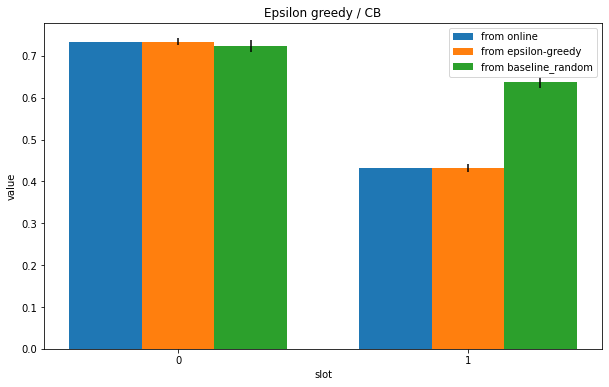

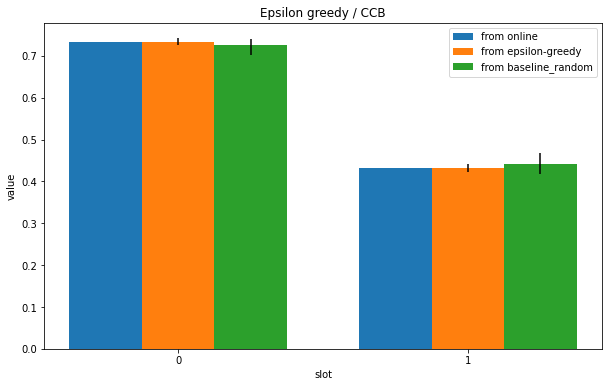

In [93]:
result = cfe_test(epsilon_greedy, log_eg, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

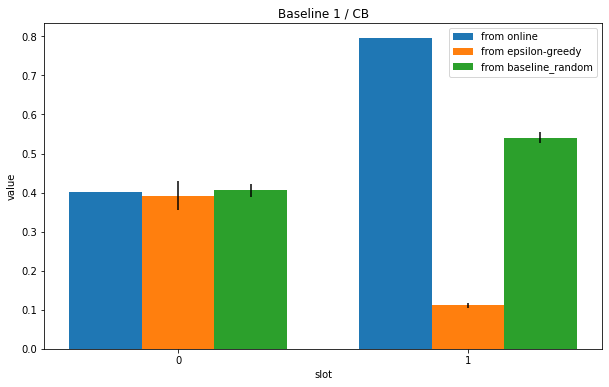

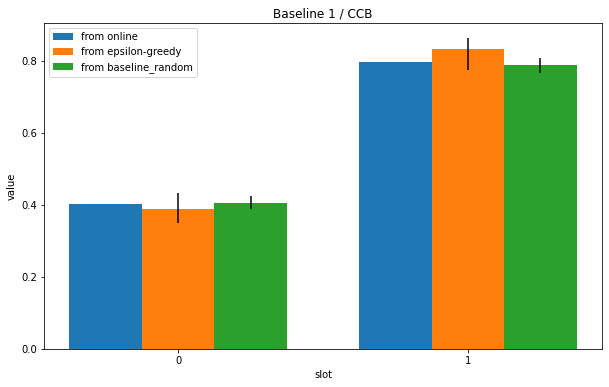

In [94]:
result = cfe_test(baseline_1(3), log_b1, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

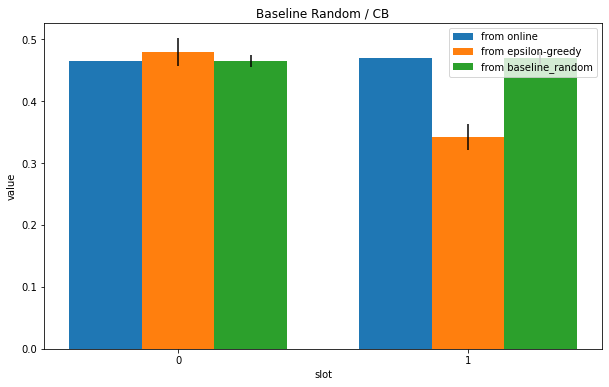

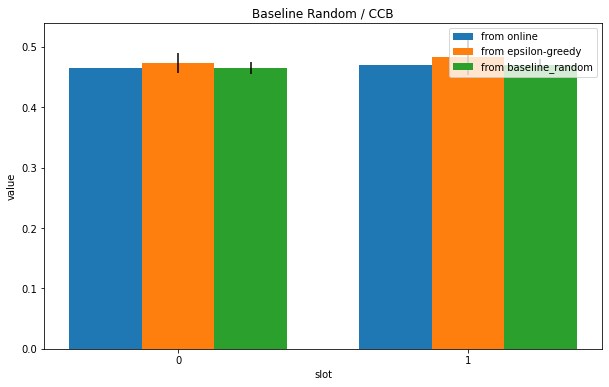

In [95]:
result = cfe_test(baseline_random(3), log_br, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

## With slot dependencies

In [96]:
epsilon = 0.2

rewards = np.array([
    [0.4, 0.8, 0.2],
    [0.2, 0.4, 0.8]])

eg = EpsilonGreedy(epsilon)
epsilon_greedy = [
    (eg.explore(3), [               #0
        (eg.explore(2), []),        #1
        (eg.exploit(2), []),        #2
    ]),
    (eg.exploit(3), [               #1
        (eg.explore(2), []),        #0
        (eg.exploit(2), []),        #2
    ]),
    (eg.explore(3), [               #2
        (eg.explore(2), []),        #0
        (eg.exploit(2), []),        #1
    ])
]

In [97]:
n = 10000
traffic = [(1, rewards)]
log_eg = CcbSimulation(n, traffic, epsilon_greedy, 'epsilon-greedy')
log_b1 = CcbSimulation(n, traffic, baseline_1(3), 'baseline_1')
log_br = CcbSimulation(n, traffic, baseline_random(3), 'baseline_random')
traffic

[(1,
  array([[0.4, 0.8, 0.2],
         [0.2, 0.4, 0.8]]))]

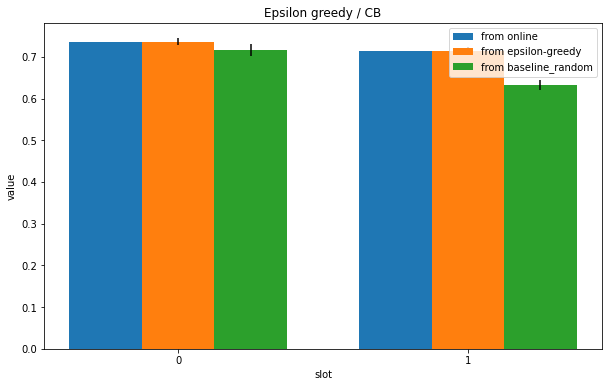

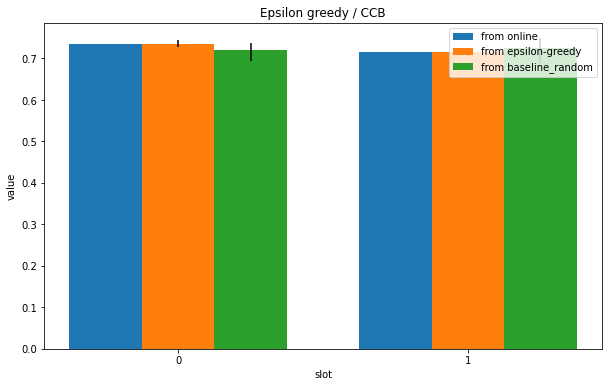

In [98]:
result = cfe_test(epsilon_greedy, log_eg, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

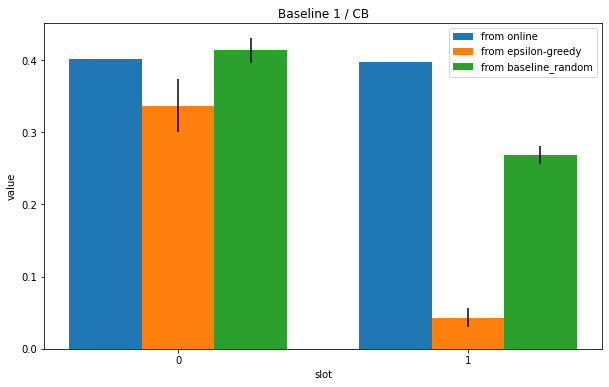

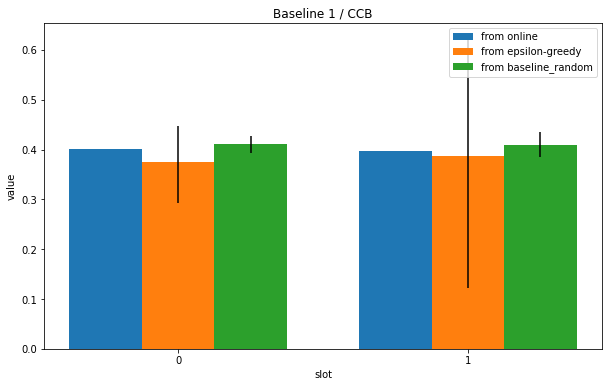

In [99]:
result = cfe_test(baseline_1(3), log_b1, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

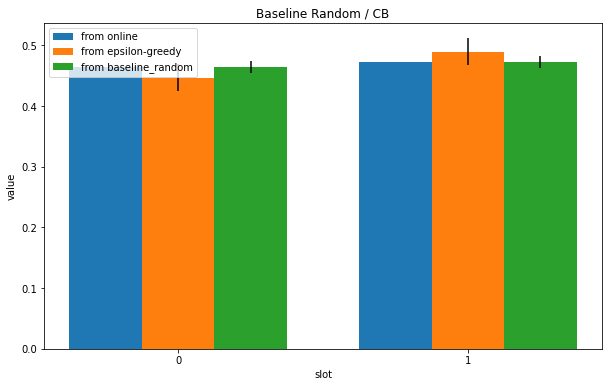

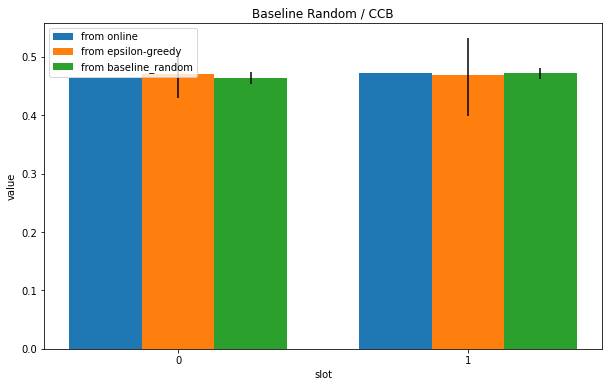

In [100]:
result = cfe_test(baseline_random(3), log_br, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

## Locked content

In [101]:
epsilon = 0.2

rewards = np.array([
    [None, 0.8, None],
    [0.4, 0.8, 0.2]])

eg = EpsilonGreedy(epsilon)
epsilon_greedy_lock0 = [
    (0, [               #0
        (eg.exploit(2), []),        #1
        (eg.explore(2), []),        #2
    ]),
    (1, [               #1
        (eg.exploit(2), []),        #0
        (eg.explore(2), []),        #2
    ]),
    (0, [               #2
        (eg.explore(2), []),        #0
        (eg.exploit(2), []),        #1
    ])
]

baseline_random_lock0 = [
    (0, [
        (1/2, []),
        (1/2, []),
    ]),
    (1, [
        (1/2, []),
        (1/2, []),
    ]),
    (0, [
        (1/2, []),
        (1/2, []),
    ])
]

baseline_1_lock0 = [
    (0, [
        (0, []),
        (0, []),
    ]),
    (1, [
        (1, []),
        (0, []),
    ]),
    (0, [
        (1, []),
        (0, []),
    ])
]

In [102]:
n = 10000
traffic = [(1, rewards)]
log_eg = CcbSimulation(n, traffic, epsilon_greedy_lock0, 'epsilon-greedy')
log_b1 = CcbSimulation(n, traffic, baseline_1_lock0, 'baseline_1')
log_br = CcbSimulation(n, traffic, baseline_random_lock0, 'baseline_random')
traffic

[(1,
  array([[None, 0.8, None],
         [0.4, 0.8, 0.2]], dtype=object))]

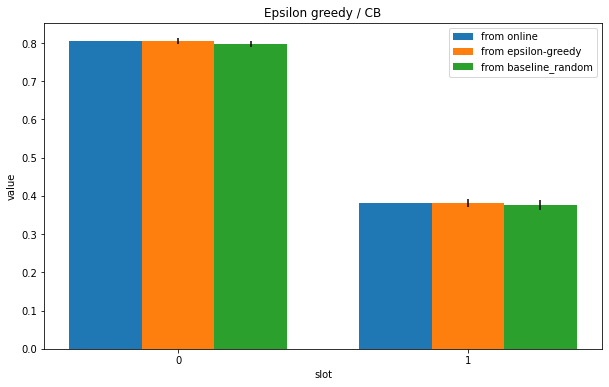

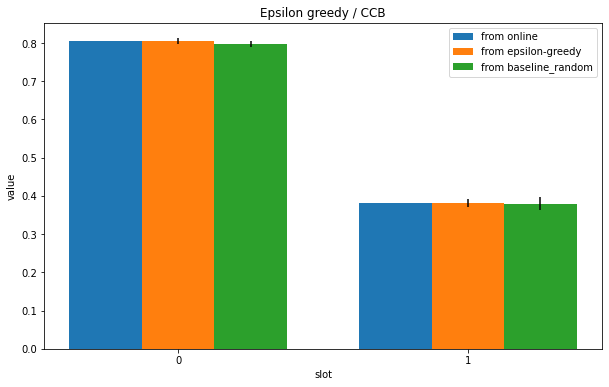

In [103]:
result = cfe_test(epsilon_greedy_lock0, log_eg, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

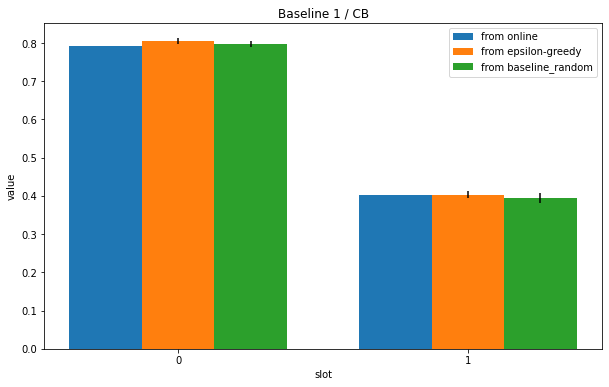

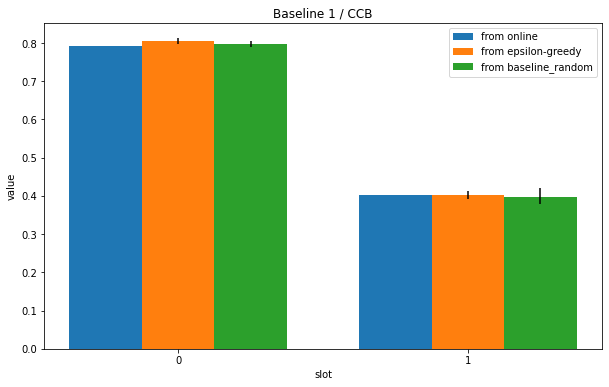

In [104]:
result = cfe_test(baseline_1_lock0, log_b1, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

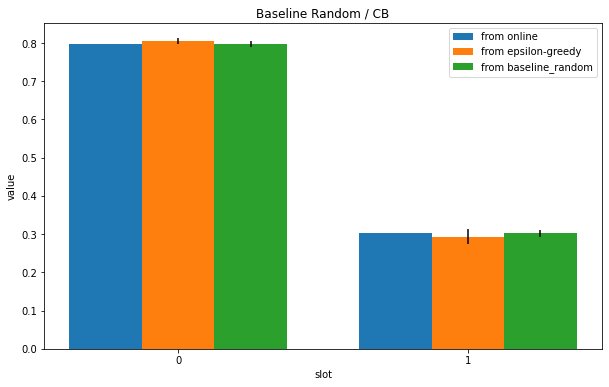

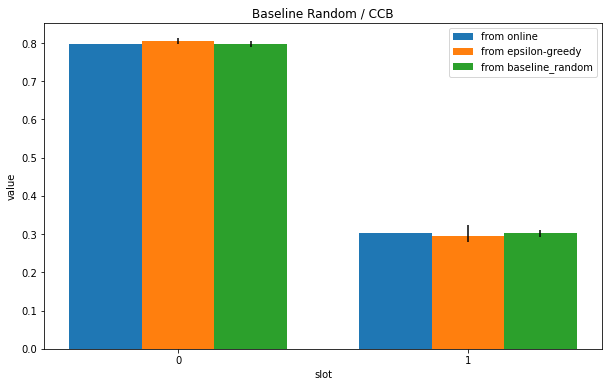

In [105]:
result = cfe_test(baseline_random_lock0, log_br, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

## Variable slots count

In [106]:
epsilon = 0.2

rewards_1 = np.array([
    [0.2, 0.8]])

rewards_2 = np.array([
    [0.2, 0.8],
    [0.4, 0.8]])

eg = EpsilonGreedy(epsilon)

epsilon_greedy = [
    (eg.explore(2), [
        (1, [])
    ]),
    (eg.exploit(2), [
        (1, [])
    ])
]

In [107]:
n = 10000
traffic = [(0.5, rewards_1), (0.5, rewards_2)]
log_eg = CcbSimulation(n, traffic, epsilon_greedy, 'epsilon-greedy')
log_b1 = CcbSimulation(n, traffic, baseline_1(2), 'baseline_1')
log_br = CcbSimulation(n, traffic, baseline_random(2), 'baseline_random')
traffic

[(0.5, array([[0.2, 0.8]])),
 (0.5, array([[0.2, 0.8],
         [0.4, 0.8]]))]

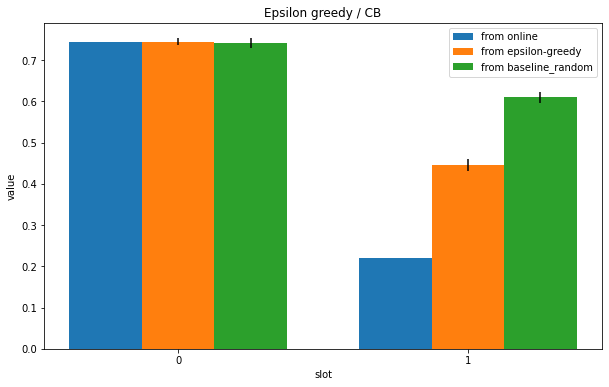

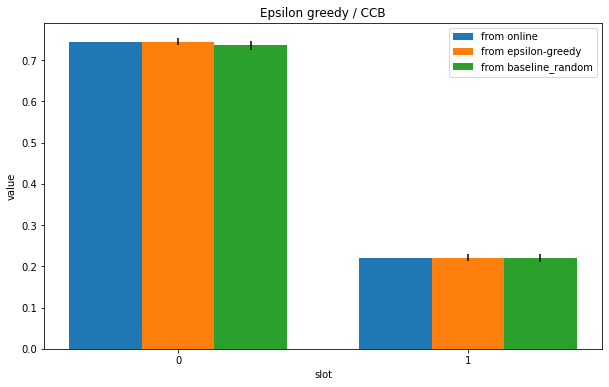

In [108]:
result = cfe_test(epsilon_greedy, log_eg, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Epsilon greedy / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

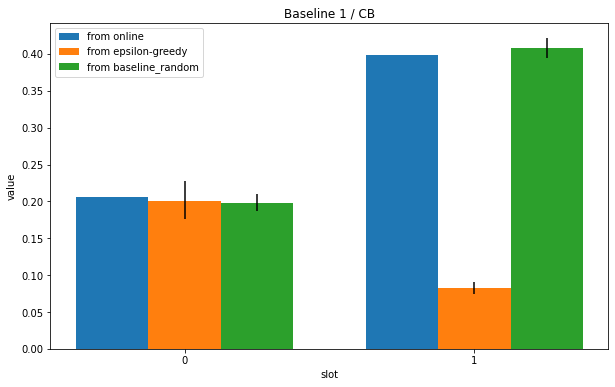

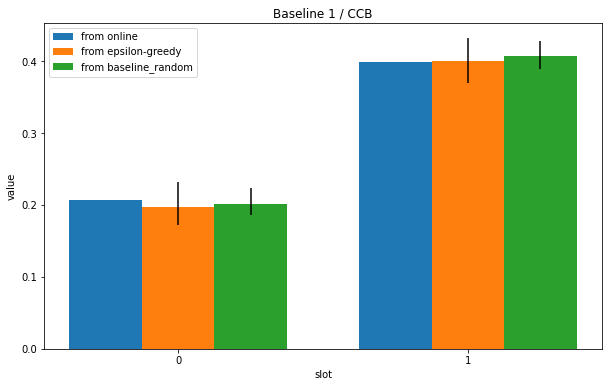

In [109]:
result = cfe_test(baseline_1(2), log_b1, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline 1 / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])

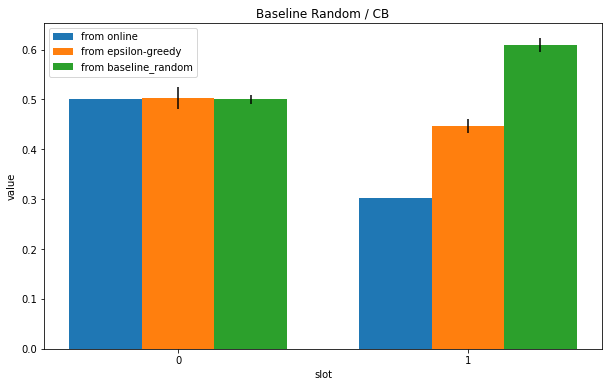

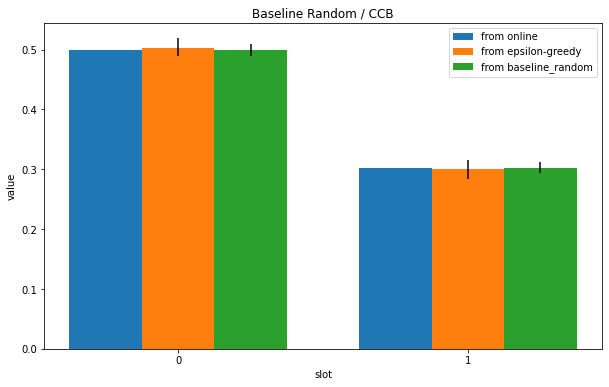

In [110]:
result = cfe_test(baseline_random(2), log_br, [log_eg, log_br])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CB')
grouped_barplot(result[result['metric'] != 'ccb'], 'slot', 'from', 'value', ['lb', 'ub'])

plt.figure(figsize=[10, 6])
plt.title('Baseline Random / CCB')
grouped_barplot(result[result['metric'] != 'cb'], 'slot', 'from', 'value', ['lb', 'ub'])